In [38]:
import os
import numpy as np
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Currently, the dataset contains a single file which represents 88588 sensor data samples collected from accelerometer and gyroscope from iPhone 5c in 10 seconds interval and ~5.4/second frequency. This data is represented by following columns (each column contains sensor data for one of the sensor's axes):

acceleration_x

acceleration_y

acceleration_z

gyro_x

gyro_y

gyro_z

There is an activity type represented by "activity" column which acts as label and reflects following activities:

"0": Do nothing

"1": walking

"2" : Running


Additionally, the dataset contains "date", "time" and "username" columns which provide information about the exact date, time and user which collected these measurements. (modifié) 

In [7]:
list_of_files = []

for root, dirs, files in os.walk("."):
    for file in files:
        if os.path.splitext(file)[1]==".csv" and ("concate" not in os.path.splitext(file)[0]) and ("data" in os.path.splitext(file)[0]):
            list_of_files.append(os.path.join(root,file))

first_data = pd.read_csv(list_of_files[0])
dataset_columns = first_data.columns
dataset_columns,list_of_files

(Index(['Timestamp', 'Acc_X', 'Acc_Y', 'Acc_Z', 'Gyr_X', 'Gyr_Y', 'Gyr_Z',
        'Activity'],
       dtype='object'),
 ['.\\data_2023-01-07_10-53-59.csv',
  '.\\data_2023-01-07_10-55-23.csv',
  '.\\data_2023-01-07_10-58-50.csv',
  '.\\data_2023-01-07_11-00-30.csv',
  '.\\data_2023-01-07_11-06-08.csv',
  '.\\data_2023-01-07_11-08-29.csv',
  '.\\data_2023-01-25_10-54-34.csv',
  '.\\data_2023-01-25_10-58-20.csv',
  '.\\data_2023-01-25_11-52-26.csv'])

In [8]:
df_run = pd.read_csv("data_2023-01-07_10-58-50.csv")
df_walk = pd.read_csv("data_2023-01-07_10-55-23.csv")
df_run.shape,df_walk.shape

((974, 8), (800, 8))

2.84

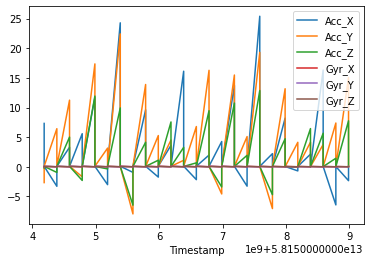

In [9]:
df_run[500:550].plot(x="Timestamp",y=dataset_columns[1:-1])
round(np.mean(df_run["Acc_X"]),2)

0.08

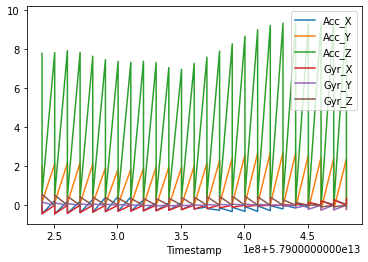

In [10]:
df_walk[500:550].plot(x="Timestamp",y=dataset_columns[1:-1])
round(np.mean(df_walk["Acc_X"]),2)

In [23]:
data = pd.DataFrame(columns=dataset_columns)


data = pd.concat([data,pd.read_csv(list_of_files[0])[dataset_columns]],ignore_index=True)
data = pd.concat([data,pd.read_csv(list_of_files[1])[dataset_columns]],ignore_index=True)
data = pd.concat([data,pd.read_csv(list_of_files[2])[dataset_columns]],ignore_index=True)
data = pd.concat([data,pd.read_csv(list_of_files[-1])[dataset_columns]],ignore_index=True)


In [24]:
data.shape

(2551, 8)

In [25]:
data.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,Activity
0,57813769498962,-1.580173,1.790863,13.895947,0.000000,0.000000,0.000000,2.0
1,57813769498962,0.005463,0.026791,0.044070,0.005463,0.026791,0.044070,2.0
2,57813969502087,-0.076614,1.886631,7.718906,0.000000,0.000000,0.000000,2.0
3,57813969502087,0.003229,0.018919,0.031852,0.003229,0.018919,0.031852,2.0
4,57814169505212,0.584185,3.016694,11.195287,0.000000,0.000000,0.000000,2.0


In [26]:
data = data.dropna()
data = data.reset_index()
data.shape

(2549, 9)

In [27]:
data.to_csv("data_concate.csv")

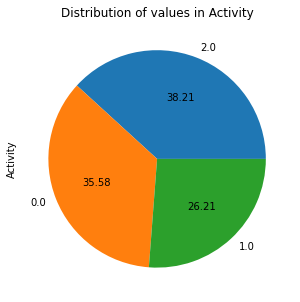

In [28]:
repartition_values = data["Activity"].value_counts()
repartition_values.plot.pie(figsize=(5, 5), autopct='%.2f')
plt.title('Distribution of values in Activity')
plt.show()

In [34]:
data = data[dataset_columns[1:]]
nbr_class = 3 #0
data.head()

,Acc_X,Acc_Y,Acc_Z,Gyr_X,Gyr_Y,Gyr_Z,Activity
0,-1.580173,1.790863,13.895947,0.000000,0.000000,0.000000,2.0
1,0.005463,0.026791,0.044070,0.005463,0.026791,0.044070,2.0
2,-0.076614,1.886631,7.718906,0.000000,0.000000,0.000000,2.0
3,0.003229,0.018919,0.031852,0.003229,0.018919,0.031852,2.0
4,0.584185,3.016694,11.195287,0.000000,0.000000,0.000000,2.0


In [36]:
x_data = data.to_numpy()

"""
scaler = StandardScaler()
x_data = data[["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z"]]
x_scaled = scaler.fit(x_data)
x_scaled = scaler.transform(x_data)

x_train_scaled = x_scaled[:int(x_scaled.shape[0]*0.8)]
x_test_scaled = x_scaled[int(x_scaled.shape[0]*0.8):]
"""

'\nscaler = StandardScaler()\nx_data = data[["Acc_X","Acc_Y","Acc_Z","Gyr_X","Gyr_Y","Gyr_Z"]]\nx_scaled = scaler.fit(x_data)\nx_scaled = scaler.transform(x_data)\n\nx_train_scaled = x_scaled[:int(x_scaled.shape[0]*0.8)]\nx_test_scaled = x_scaled[int(x_scaled.shape[0]*0.8):]\n'

In [31]:
def df_to_batch(n_future,n_past,data):
    data = data.to_numpy()
    x_ = []


    for i in range(n_past,len(data)-n_future+1):
        x_.append(data[i-n_past:i,0:data.shape[1]])
       
    x_ = np.array(x_)
    return x_


In [64]:
x_ = []
y_ = []

n_future = 1
n_past = 50

for i in range(n_past,len(x_data)-n_future+1):
    x_.append(x_data[i-n_past:i,0:x_data.shape[1]-1])
    y_value = np.zeros((nbr_class))
    y_value[int(data["Activity"][i])]=1
    y_.append(y_value)
    
x_ = np.array(x_)
y_ = np.array(y_)

x_.shape,y_.shape,y_[0]

((2499, 50, 6), (2499, 3), array([0., 1., 0.]))

In [65]:
x_,y_ = shuffle(x_, y_)

In [66]:
x_train,y_train = x_[:int(x_.shape[0]*0.8)],y_[:int(x_.shape[0]*0.8)]
x_test,y_test = x_[int(x_.shape[0]*0.8):],y_[int(x_.shape[0]*0.8):]
x_train.shape,x_test.shape

((1999, 50, 6), (500, 50, 6))

(array([0, 1, 2], dtype=int64), array([182, 138, 180], dtype=int64)) (array([0, 1, 2], dtype=int64), array([725, 498, 776], dtype=int64))


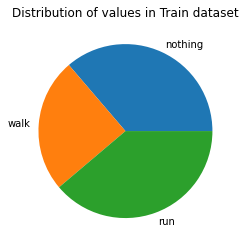

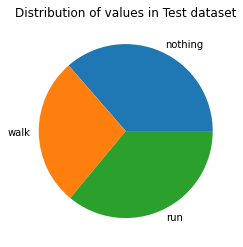

In [69]:
y_train_label,y_test_label = np.apply_along_axis(np.argmax,-1,y_train),np.apply_along_axis(np.argmax,-1,y_test)

y_train_count_label = np.unique(y_train_label, return_counts=True)
y_test_count_label = np.unique(y_test_label, return_counts=True)
print(y_test_count_label,y_train_count_label)

plt.pie(y_train_count_label[1],labels=["nothing","walk","run"])
plt.title('Distribution of values in Train dataset')
plt.show()

plt.pie(y_test_count_label[1],labels=["nothing","walk","run"])
plt.title('Distribution of values in Test dataset')
plt.show()


In [101]:
def lstm_model():
    
    inputs = layers.Input(shape=(x_train.shape[1],x_train.shape[2]), name="input")
    lstm_1 = layers.LSTM(50, activation="relu",return_sequences=True,name="lstm_layer_1")(inputs)
    lstm_2 = layers.LSTM(25, activation="relu",return_sequences=False,name="lstm_layer_2")(lstm_1)
    dropout = layers.Dropout(0.1)(lstm_2)
    output = layers.Dense(nbr_class,activation="softmax")(dropout)
    
    model = Model(inputs,output)
    
    return model

In [106]:
my_model = lstm_model()
my_model.compile(optimizer="adam",loss="mse")
my_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50, 6)]           0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 50, 50)            11400     
                                                                 
 lstm_layer_2 (LSTM)         (None, 25)                7600      
                                                                 
 dropout_8 (Dropout)         (None, 25)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 78        
                                                                 
Total params: 19,078
Trainable params: 19,078
Non-trainable params: 0
_________________________________________________________________


In [107]:
history = my_model.fit(x_train,y_train,epochs=30,batch_size=64,
                       validation_split=0.1,
                       verbose=1)

Epoch 1/30
29/29 [==============================] - 6s 81ms/step - loss: 0.1307 - val_loss: 0.0881
Epoch 2/30
29/29 [==============================] - 2s 53ms/step - loss: 0.0715 - val_loss: 0.0754
Epoch 3/30
29/29 [==============================] - 2s 59ms/step - loss: 0.2059 - val_loss: 0.3967
Epoch 4/30
29/29 [==============================] - 2s 59ms/step - loss: 0.4141 - val_loss: 0.4100
Epoch 5/30
29/29 [==============================] - 2s 59ms/step - loss: 0.4184 - val_loss: 0.3900
Epoch 6/30
29/29 [==============================] - 2s 61ms/step - loss: 0.4207 - val_loss: 0.4033
Epoch 7/30
29/29 [==============================] - 2s 59ms/step - loss: 0.4033 - val_loss: 0.3067
Epoch 8/30
29/29 [==============================] - 2s 57ms/step - loss: 0.3854 - val_loss: 0.3833
Epoch 9/30
29/29 [==============================] - 2s 55ms/step - loss: 0.4162 - val_loss: 0.3833
Epoch 10/30
29/29 [==============================] - 2s 56ms/step - loss: 0.4178 - val_loss: 0.3900
Epoch 11/

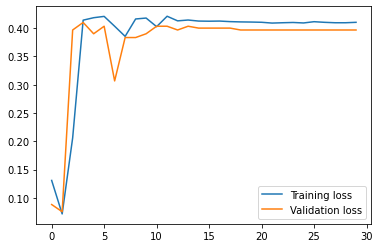

In [108]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [109]:
acc = 0

for i in range(n_future,int(len(y_test)/10)):
    i_ = i*10
    prediction = my_model.predict(x_test[i_-(n_future):i_])
    #print("shape prediction = {}".format(prediction.shape))
    if np.argmax(y_test[i_]) == np.argmax(prediction):
        acc += 1/(len(x_test))*10
    print("label: {} - result {} - accuracy - {}".format(np.argmax(y_test[i_]),np.argmax(prediction),round(acc,2)),end="\r")
print("accuracy = {}%                              ".format(round(acc*100)))

accuracy = 61%                              


In [77]:
run_model = tf.function(lambda x: my_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = x_train.shape[1] 
INPUT_SIZE = x_train.shape[2]
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], my_model.inputs[0].dtype))



save_dir = 'saved_model/model_activity_prediction'
# model directory.
my_model.save(save_dir, save_format="tf", signatures=concrete_func)

INFO:tensorflow:Assets written to: saved_model/model_activity_prediction\assets


INFO:tensorflow:Assets written to: saved_model/model_activity_prediction\assets


In [78]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_dir)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [79]:
#Run the model with TensorFlow to get expected results.
TEST_CASES = 500

# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

for i in range(TEST_CASES):
    expected = my_model.predict(x_test[i:i+1])
    x_test_f32 = x_test.astype(np.float32)
    interpreter.set_tensor(input_details[0]["index"], x_test_f32[i:i+1, :, :])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    print(result)

    # Assert if the result of TFLite model is consistent with the TF model.
    np.testing.assert_almost_equal(expected, result, decimal=5)
    print("{} Done. The result of TensorFlow matches the result of TensorFlow Lite.".format(result),end="\r")

    # Please note: TfLite fused Lstm kernel is stateful, so we need to reset
    # the states.
    # Clean up internal states.
    interpreter.reset_all_variables()

[[9.9344540e-01 6.3826609e-03 1.7196391e-04]]
[[3.0430664e-22 9.8946173e-25 1.0000000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.33914152 0.64112234 0.01973615]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[9.9341500e-01 6.4156638e-03 1.6937665e-04]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.99363226 0.00505388 0.00131384]]665e-04]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[2.4923481e-26 7.6526810e-32 1.0000000e+00]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.01074989 0.01353838 0.9757117 ]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.44332448 0.5250612  0.03161435]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[9.9315333e-01 6.6693947e-03 1.7723892e-04]]e result of TensorFlow matches the result of TensorFlow Lite.
[[8.5103002e-06 5.3444675e-09 9.9999154e-01]] Done. The result

[[0.4581583  0.48624068 0.05560092]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.38631308 0.5738338  0.0398531 ]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.46336943 0.52006483 0.01656569]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.9934062  0.00526759 0.00132625]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.36845744 0.6140543  0.01748833]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.34321034 0.64903235 0.00775732]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.00899299 0.0051814  0.9858256 ]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[7.5483399e-08 1.8852671e-11 9.9999988e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.3868803  0.60055757 0.01256211]]988e-01]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.95875823 0.0366

[[0.3960485  0.59221816 0.01173339]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[2.4979791e-14 3.4594441e-15 1.0000000e+00]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.9936888  0.00500867 0.00130243]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.4633283  0.50765866 0.02901297]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.46216583 0.5081139  0.02972029]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[1.2292097e-07 4.1384069e-15 9.9999988e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.43691155 0.49742028 0.06566814]]988e-01]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.36048308 0.60639274 0.0331242 ]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[3.6920741e-04 1.7343012e-06 9.9962902e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.08379119 0.9109

[[6.08e-43 0.00e+00 1.00e+00]]6443]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[2.4358833e-13 1.1567624e-17 1.0000000e+00]]lt of TensorFlow matches the result of TensorFlow Lite.
[[0.38391373 0.60881984 0.00726647]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[1.03915015e-10 2.19384060e-12 1.00000000e+00]]esult of TensorFlow matches the result of TensorFlow Lite.
[[5.048888e-07 5.526405e-14 9.999995e-01]]e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[1.1720632e-01 8.8246858e-01 3.2508830e-04]]ne. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.43217057 0.51283634 0.05499305]]830e-04]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[9.9345797e-01 6.3705728e-03 1.7144733e-04]]e result of TensorFlow matches the result of TensorFlow Lite.
[[2.4221092e-17 6.2791810e-20 1.0000000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite

[[2.3566619e-08 1.3209606e-21 1.0000000e+00]]e result of TensorFlow matches the result of TensorFlow Lite.
[[6.6753319e-07 1.2470995e-08 9.9999928e-01]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[3.9099083e-15 1.5486002e-22 1.0000000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.99358094 0.00510761 0.00131138]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.38265133 0.60762715 0.00972146]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.9937734  0.00494306 0.00128361]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[1.4186691e-04 2.8627495e-10 9.9985814e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.11007059 0.16094194 0.72898746]]814e-01]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.09358466 0.9041766  0.00223869]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[

[[0.26645258 0.6565248  0.07702265]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.44356185 0.518849   0.03758917]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.99346536 0.00520387 0.00133083]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[7.6267997e-10 4.2419965e-15 1.0000000e+00]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.99336314 0.00528425 0.00135257]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.3765888  0.60646904 0.01694218]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.4739301  0.51797324 0.00809671]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[8.3664897e-09 1.4249858e-12 1.0000000e+00]]e result of TensorFlow matches the result of TensorFlow Lite.
[[0.35288662 0.612046   0.03506734]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[9.9347067e-01 6.3

[[0.39343742 0.58432406 0.02223858]]142e-04]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[2.8890906e-07 2.4883206e-14 9.9999976e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[7.4090675e-15 1.4241137e-23 1.0000000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.99349254 0.00518355 0.0013239 ]]000e+00]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[0.07823967 0.91801697 0.00374339]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[9.7877532e-04 1.7559582e-04 9.9884558e-01]]e result of TensorFlow matches the result of TensorFlow Lite.
[[6.799161e-06 3.530029e-18 9.999932e-01]]1]] Done. The result of TensorFlow matches the result of TensorFlow Lite.
[[1.84965194e-12 1.12957985e-14 1.00000000e+00]] The result of TensorFlow matches the result of TensorFlow Lite.
[[0.43793735 0.5405409  0.02152178]]000000e+00]] Done. The result of TensorFlow matches the result of 

In [81]:
df_pred = pd.read_csv("pred/prediction_file.csv")
df_pred_good_feature = df_pred[df_pred.columns[1:-1]]

df_pred_good_feature.shape,df_pred_good_feature.head()

((668, 6),
       Acc_X     Acc_Y     Acc_Z     Gyr_X     Gyr_Y     Gyr_Z
 0  0.047884 -0.162806  9.758766  0.000000  0.000000  0.000000
 1  0.000122 -0.000017  0.003037  0.000122 -0.000017  0.003037
 2  0.047884 -0.143652  9.730036  0.000000  0.000000  0.000000
 3  0.000087 -0.000035  0.003019  0.000087 -0.000035  0.003019
 4  0.038307 -0.153229  9.758766  0.000000  0.000000  0.000000)

In [85]:
data_pred = df_to_batch(2,50,df_pred_good_feature)
data_pred.shape

(617, 50, 6)

In [86]:
model_pred = tf.keras.models.load_model('saved_model/model_activity_prediction')

In [88]:
NOTHING=WALK=RUN=0
for d in data_pred:
    d = d.reshape(1,50,6)
    pred = np.array(model_pred.predict(d)[0])
    if np.argmax(pred)==0:
        NOTHING+=1
    if np.argmax(pred)==1:
        WALK +=1
    if np.argmax(pred)==2:
        RUN+=1
        
    print("{},{},{}".format(NOTHING,WALK,RUN),end="\r")


    